In [20]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai

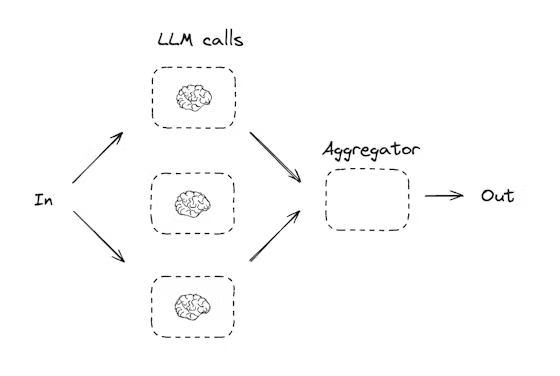

In [21]:
from typing_extensions  import TypedDict
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


In [22]:
# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


In [25]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
# os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [26]:
from langgraph.graph import START, StateGraph, END
# from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()


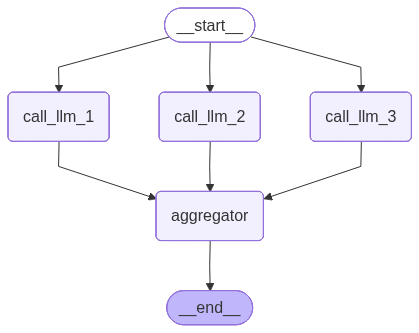

In [27]:

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))


In [28]:
# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
In a quaint little town nestled between lush green hills, there was a mysterious old bookshop called "Whiskers & Wonders." The shop was rumored to be enchanted, but most folks dismissed it as just another whimsical tale. The owner, an eccentric elderly gentleman named Mr. Pawsworth, was known for his curly white mustache and penchant for velvet waistcoats. However, it wasn't just Mr. Pawsworth who captured the hearts of the townsfolk; it was his collection of cats — a delightful mix of tabbies, calicos, and long-haired beauties — each with a personality as vivid as the stories that lined the shelves.

Every evening, as the sun dipped below the horizon and painted the sky in shades of pink and gold, the cats would gather in the window of the bookshop. Their bright eyes reflected the glow of the warm light inside, drawing in curious passersby. Many stopped to admire the feline crew: a regal Siamese named Sir Purrcival, a mischievous ging